~ Lab Assignment 4

~ Rhythm Rajesh Shah

~ 1233960561

~ 02/22/2025

### Code Cell 1 (5%) - Import all the necessary libraries and restaurant review data.

In [6]:
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
from keras.layers import TextVectorization
from keras.utils import pad_sequences
import tensorflow as tf
warnings.filterwarnings("ignore")
from tqdm import tqdm

In [7]:
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 184.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [8]:
import spacy
nlp = spacy.load("en_core_web_sm")
import nltk

In [9]:
df = pd.read_csv("restaurant_reviews_az.csv")
df.head(5)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,IVS7do_HBzroiCiymNdxDg,fdFgZQQYQJeEAshH4lxSfQ,sGy67CpJctjeCWClWqonjA,3,1,1,0,"OK, the hype about having Hatch chili in your ...",2020-01-27 22:59:06
1,QP2pSzSqpJTMWOCuUuyXkQ,JBLWSXBTKFvJYYiM-FnCOQ,3w7NRntdQ9h0KwDsksIt5Q,5,1,1,1,Pandemic pit stop to have an ice cream.... onl...,2020-04-19 05:33:16
2,oK0cGYStgDOusZKz9B1qug,2_9fKnXChUjC5xArfF8BLg,OMnPtRGmbY8qH_wIILfYKA,5,1,0,0,I was lucky enough to go to the soft opening a...,2020-02-29 19:43:44
3,E_ABvFCNVLbfOgRg3Pv1KQ,9MExTQ76GSKhxSWnTS901g,V9XlikTxq0My4gE8LULsjw,5,0,0,0,I've gone to claim Jumpers all over the US and...,2020-03-14 21:47:07
4,Rd222CrrnXkXukR2iWj69g,LPxuausjvDN88uPr-Q4cQA,CA5BOxKRDPGJgdUQ8OUOpw,4,1,0,0,"If you haven't been to Maynard's kitchen, it'...",2020-01-17 20:32:57


### Code Cell 2 (5%) -  Remove 3-star reviews from the input data and create a new column - Sentiment for the remaining reviews. For reviews with 1 or 2 star ratings, set the value in the Sentiment column to 0. For reviews with 4 or 5-star ratings, set the value in the sentiment column to 1. 

In [10]:
df = df[df['stars'] != 3]

df['Sentiment'] = df['stars'].apply(lambda x: 1 if x > 3 else 0)

df.head(5)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,Sentiment
1,QP2pSzSqpJTMWOCuUuyXkQ,JBLWSXBTKFvJYYiM-FnCOQ,3w7NRntdQ9h0KwDsksIt5Q,5,1,1,1,Pandemic pit stop to have an ice cream.... onl...,2020-04-19 05:33:16,1
2,oK0cGYStgDOusZKz9B1qug,2_9fKnXChUjC5xArfF8BLg,OMnPtRGmbY8qH_wIILfYKA,5,1,0,0,I was lucky enough to go to the soft opening a...,2020-02-29 19:43:44,1
3,E_ABvFCNVLbfOgRg3Pv1KQ,9MExTQ76GSKhxSWnTS901g,V9XlikTxq0My4gE8LULsjw,5,0,0,0,I've gone to claim Jumpers all over the US and...,2020-03-14 21:47:07,1
4,Rd222CrrnXkXukR2iWj69g,LPxuausjvDN88uPr-Q4cQA,CA5BOxKRDPGJgdUQ8OUOpw,4,1,0,0,"If you haven't been to Maynard's kitchen, it'...",2020-01-17 20:32:57,1
5,kx6O_lyLzUnA7Xip5wh2NA,YsINprB2G1DM8qG1hbrPUg,rViAhfKLKmwbhTKROM9m0w,1,0,0,0,I stay at the Main Hotel at the Casino from Ju...,2020-07-14 16:43:23,0


### Code Cell 3 (10%) - Conduct necessary data processing. Prepare the training and test sets on review data for machine learning classifications. 20% of the data is for testing, and 80% of the data is for training. 

In [11]:
# Process the dataset in chunks
def process_in_chunks(df, chunk_size=1000, batch_size=500, lowercase=True, remove_stopwords=True):
    results = []

    for i in tqdm(range(0, len(df), chunk_size)):  # Loop through the dataset in chunks
        chunk = df['text'].iloc[i:i+chunk_size].tolist()

        # Process each chunk using spaCy's pipe for efficiency
        processed_chunk = []
        for doc in nlp.pipe(chunk, batch_size=batch_size, n_process=1):  # Use a limited number of processes
            processed_chunk.append(normalize_single_review(doc, lowercase=lowercase, remove_stopwords=remove_stopwords))

        results.extend(processed_chunk)  # Add the processed chunk to results

    return results

In [12]:
#methods from nltk
# to remove non alphanumeric character
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

# to remove URLs
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# to remove html tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [13]:
# apply preprocessing steps
df['text'] = df['text'].apply(remove_URL)
print("remove_URL function done")
df['text'] = df['text'].apply(remove_html)
print("remove_html function done")
df['text'] = df['text'].apply(alpha_num)
print("alpha_num function done")
# Apply the chunked processing to the entire dataframe
# df['review'] = df['review'].apply(normalize,lowercase=True, remove_stopwords=True)
df['preview'] = process_in_chunks(df, chunk_size=1000, batch_size=500, lowercase=True, remove_stopwords=True)

# Display the processed dataframe
df.head()

remove_URL function done
remove_html function done
alpha_num function done


100%|██████████| 45/45 [04:08<00:00,  5.52s/it]


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,Sentiment,preview
1,QP2pSzSqpJTMWOCuUuyXkQ,JBLWSXBTKFvJYYiM-FnCOQ,3w7NRntdQ9h0KwDsksIt5Q,5,1,1,1,Pandemic pit stop to have an ice cream only pl...,2020-04-19 05:33:16,1,pandemic pit stop ice cream plain sundae limit...
2,oK0cGYStgDOusZKz9B1qug,2_9fKnXChUjC5xArfF8BLg,OMnPtRGmbY8qH_wIILfYKA,5,1,0,0,I was lucky enough to go to the soft opening a...,2020-02-29 19:43:44,1,lucky soft opening let tell good beer wine dif...
3,E_ABvFCNVLbfOgRg3Pv1KQ,9MExTQ76GSKhxSWnTS901g,V9XlikTxq0My4gE8LULsjw,5,0,0,0,Ive gone to claim Jumpers all over the US and ...,2020-03-14 21:47:07,1,ve go claim jumper disappoint location differe...
4,Rd222CrrnXkXukR2iWj69g,LPxuausjvDN88uPr-Q4cQA,CA5BOxKRDPGJgdUQ8OUOpw,4,1,0,0,If you havent been to Maynards kitchen its ti...,2020-01-17 20:32:57,1,not maynards kitchen time hope dinner sure r...
5,kx6O_lyLzUnA7Xip5wh2NA,YsINprB2G1DM8qG1hbrPUg,rViAhfKLKmwbhTKROM9m0w,1,0,0,0,I stay at the Main Hotel at the Casino from Ju...,2020-07-14 16:43:23,0,stay main hotel casino july 11 july 13 bad exp...


In [14]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(df['preview'], df['Sentiment'], test_size=0.2, random_state=5, stratify=df['Sentiment'])

### Code Cell 4 (10%) - Download the pre-trained GloVe word embeddings (glove.6B.100d.txt) and prepare the embedding matrix for this review dataset.

In [15]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2025-02-24 00:38:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-02-24 00:38:28--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-02-24 00:38:28--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [16]:
# Model Parameters
embedding_dim = 100  # Size of the word embedding vectors
max_length = 100  # Maximum length of input sequences (for padding/truncation)
trunc_type = 'post'  # Truncate sequences from the end if they exceed max_length
padding_type = 'post'  # Pad sequences at the end if they are shorter than max_length

# Define Vocabulary Size
vocab_size = 20000  # Limit vocabulary size to 20,000 words
oov_token = "<OOV>"  # Token for out-of-vocabulary words (OOV handling)

# Create a TextVectorization Layer
vectorizer = TextVectorization(
    max_tokens=vocab_size,  # Define vocabulary size
    output_mode="int"  # Convert words into integer sequences
)

# Adapt the vectorizer to the training dataset (build vocabulary from training sentences)
vectorizer.adapt(train_sentences)

train_sequences = vectorizer(tf.constant(train_sentences))
test_sequences = vectorizer(tf.constant(test_sentences))

# Retrieve vocabulary and create a word index mapping (word → integer ID)
vocab = vectorizer.get_vocabulary()
word_index = {word: idx for idx, word in enumerate(vocab)}

# Get the actual vocabulary size (including OOV and mask tokens)
vocab_size = vectorizer.vocabulary_size()
print("Vocabulary size including optional mask and OOV indices is: ", vocab_size)

I0000 00:00:1740358156.740640    4245 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740358156.741634    4245 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740358156.742153    4245 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740358156.742681    4245 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Vocabulary size including optional mask and OOV indices is:  20000


In [17]:
# Pad sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
# convert validation dataset to sequence and pad sequences
test_sequences = vectorizer(tf.constant(test_sentences))
test_padded = pad_sequences(test_sequences, padding=padding_type,truncating=trunc_type, maxlen=max_length)

In [18]:
# Define the path to the pre-trained GloVe embeddings file
EMBEDDING_FILE = 'glove.6B.100d.txt'  # Change file name if using a different GloVe version

# Initialize an empty dictionary to store word embeddings
word_vectors = {}

# Open the GloVe file and read the embeddings
with open(EMBEDDING_FILE, encoding="utf8") as f:
    for line in f:
        values = line.split()  # Split each line into word + embedding values
        word = values[0]  # The first value in the line is the word
        coefs = np.asarray(values[1:], dtype='float32')  # The remaining values are the embedding coefficients
        word_vectors[word] = coefs  # Store the word and its corresponding embedding in the dictionary


In [19]:
# Initialize an embedding matrix with zeros
# Shape: (vocab_size + 1, embedding_dim)
#   - vocab_size + 1: Extra row for padding index (zero index)
#   - embedding_dim: Each word vector's dimension (e.g., 100 for GloVe 100D)
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))

# Iterate over the word_index dictionary (word → integer mapping)
for word, i in word_index.items():
    # Retrieve the pre-trained embedding vector for the word
    embedding_vector = word_vectors.get(word)
    # If the word exists in GloVe embeddings, store its vector in the matrix
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  # Assign the vector to its corresponding index


In [22]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.16486   ,  0.91996998,  0.22736999, ..., -0.067904  ,
         1.5072    ,  0.60889   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### Code Cell 5 (10%) -  Build a GRU model with pre-trained GloVe embedding and show model performance

In [24]:
from keras.layers import Input, Embedding, GRU, Dense

# Ensure these variables are defined correctly
# word_index: Dictionary mapping words to integer indices
# embedding_dim: Dimension of the GloVe word vectors (e.g., 50, 100, 300)
# max_length: Maximum length of input sequences
# embedding_matrix: Pre-trained GloVe embeddings (shape: (vocab_size, embedding_dim))

# Define input layer (1D input for sequences)
input_layer = Input(shape=(max_length,))  # Matches input_length in Embedding

# Embedding layer using pre-trained GloVe
embedding_layer = Embedding(
    input_dim=len(word_index) + 1,  # Vocabulary size (+1 for padding token)
    output_dim=embedding_dim,       # Embedding dimension (matches GloVe)
    input_length=max_length,        # Sequence length (fixed for model input)
    weights=[embedding_matrix],     # Load pre-trained embeddings
    trainable=False                 # Freeze embeddings (prevent updates)
)(input_layer)

# GRU layer (receives input of shape (batch_size, max_length, embedding_dim))
gru_layer = GRU(64, return_sequences=False)(embedding_layer)

# Fully connected layers
dense_layer = Dense(24, activation='relu')(gru_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)  # Binary classification output

# Define the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 100)       │     2,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        31,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,033,557 (7.76 MB)

 Trainable params: 33,457 (130.69 KB)

 Non-trainable params: 2,000,100 (7.63 MB)

In [25]:
# fit model
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True)

# num_epochs = 50
num_epochs=50
history = model.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)

Epoch 1/50


2025-02-24 01:34:50.603665: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


772/772 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7252 - loss: 0.5866 - val_accuracy: 0.7208 - val_loss: 0.5920
Epoch 2/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7290 - loss: 0.5841 - val_accuracy: 0.7324 - val_loss: 0.5793
Epoch 3/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7316 - loss: 0.5788 - val_accuracy: 0.8919 - val_loss: 0.2760
Epoch 4/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9108 - loss: 0.2262 - val_accuracy: 0.9267 - val_loss: 0.1832
Epoch 5/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9370 - loss: 0.1646 - val_accuracy: 0.9322 - val_loss: 0.1658
Epoch 6/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9437 - loss: 0.1546 - val_accuracy: 0.9349 - val_loss: 0.1574
Epoch 7/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9476 - loss: 0.1397 - val_accuracy: 0.9373 - val_loss: 0.1517
Epoch 8/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9536 - loss: 0.1247 - val_accuracy: 0.9396 - val_

In [26]:
# Method to plot models accuracy/loss

def plot_history(history):

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', c='green', lw='2')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', c='orangered', lw='2')
    plt.title('Accuracy', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', c='green', lw='2')
    plt.plot(history.history['val_loss'], label='Validation Loss', c='orangered', lw='2')
    plt.title('Loss', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9418 - loss: 0.1478


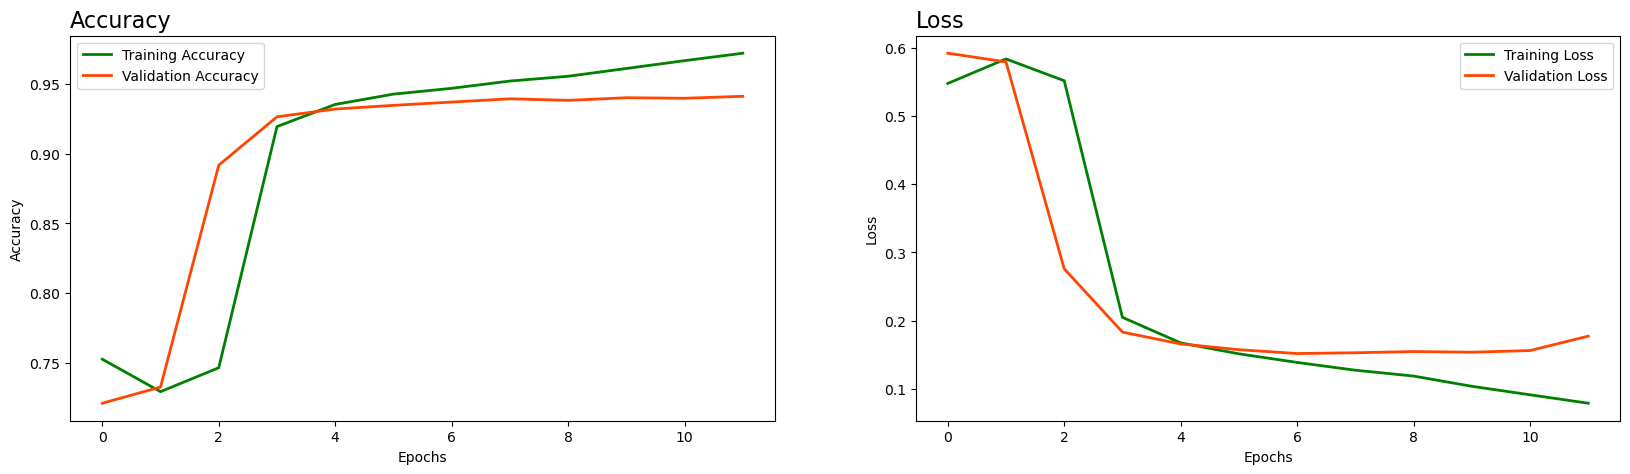

In [36]:
results = model.evaluate(test_padded, test_labels, verbose=1)
plot_history(history)

In [37]:
predictions = model.predict(test_padded)
model_prediction = np.where(predictions > 0.5, 1, 0)
from sklearn import metrics
model_performance = metrics.classification_report(test_labels,model_prediction, target_names= ['0', '1'])
print(model_performance)

276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2463
           1       0.96      0.96      0.96      6356

    accuracy                           0.94      8819
   macro avg       0.93      0.93      0.93      8819
weighted avg       0.94      0.94      0.94      8819



### Code Cell 6 (10%) - Build an LSTM model with pre-trained GloVe embedding and show model performance 

In [38]:
from keras.layers import Input, Embedding, LSTM, Dense

# Ensure word_index, embedding_dim, max_length, and embedding_matrix are defined
# word_index: Dictionary mapping words to integer indices
# embedding_dim: Dimension of the GloVe embeddings (e.g., 50, 100, 300)
# max_length: Maximum sequence length for input data
# embedding_matrix: Pre-trained GloVe embedding matrix (shape: (vocab_size, embedding_dim))

# Define input layer
input_layer = Input(shape=(max_length,))  # Shape should match the input_length

# Embedding layer with pre-trained GloVe (Non-trainable)
embedding_layer = Embedding(
    input_dim=len(word_index) + 1,  # Vocabulary size (+1 for padding token)
    output_dim=embedding_dim,       # Embedding dimension (matches GloVe)
    input_length=max_length,        # Sequence length (fixed for model input)
    weights=[embedding_matrix],     # Load pre-trained embeddings
    trainable=False                 # Freeze GloVe embeddings (set True for fine-tuning)
)(input_layer)

# LSTM layer
lstm_layer = LSTM(64)(embedding_layer)

# Fully connected layers
dense_layer = Dense(24, activation='relu')(lstm_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)  # Binary classification output

# Define the Functional model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     2,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,043,925 (7.80 MB)

 Trainable params: 43,825 (171.19 KB)

 Non-trainable params: 2,000,100 (7.63 MB)

In [40]:
# fit model
early_stop = EarlyStopping(monitor='val_loss', patience=3, mode='auto', restore_best_weights=True)
num_epochs=50
# num_epochs = 2
history = model.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)

Epoch 1/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7399 - loss: 0.5626 - val_accuracy: 0.7339 - val_loss: 0.5690
Epoch 2/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8189 - loss: 0.4265 - val_accuracy: 0.9175 - val_loss: 0.2181
Epoch 3/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9263 - loss: 0.1999 - val_accuracy: 0.9295 - val_loss: 0.1828
Epoch 4/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9399 - loss: 0.1596 - val_accuracy: 0.9322 - val_loss: 0.1706
Epoch 5/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9436 - loss: 0.1462 - val_accuracy: 0.9348 - val_loss: 0.1716
Epoch 6/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9486 - loss: 0.1366 - val_accuracy: 0.9352 - val_loss: 0.1669
Epoch 7/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9586 - loss: 0.1173 - val_accuracy: 0.9391 - val_loss: 0.1527
Epoch 8/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9586 - loss: 0.1120 - val_accuracy: 0.

276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9380 - loss: 0.1518


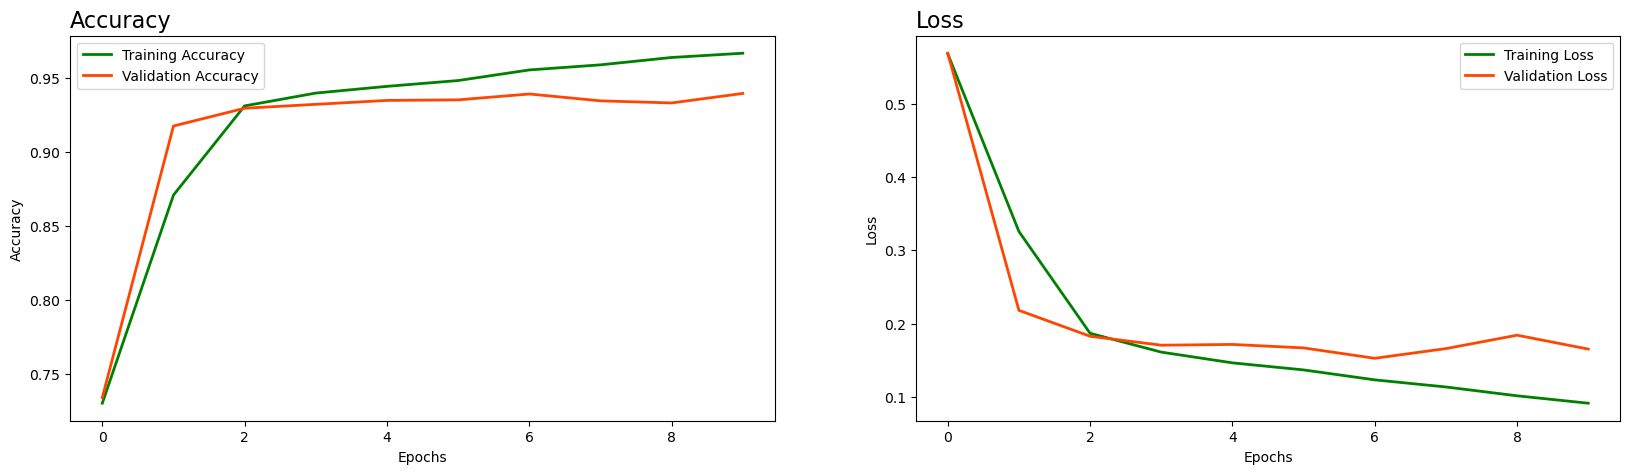

In [41]:
results = model.evaluate(test_padded, test_labels, verbose=1)
plot_history(history)

In [42]:
predictions = model.predict(test_padded)
model_prediction = np.where(predictions > 0.5, 1, 0)
from sklearn import metrics
model_performance = metrics.classification_report(test_labels,model_prediction, target_names= ['0', '1'])
print(model_performance)

276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2463
           1       0.95      0.96      0.96      6356

    accuracy                           0.94      8819
   macro avg       0.93      0.92      0.92      8819
weighted avg       0.94      0.94      0.94      8819



### Code Cell 7 (10%) - Build a GRU model with trainable GloVe embeddings and show model performance 

In [43]:
from keras.layers import Input, Embedding, GRU, Dense

# Ensure these variables are defined correctly
# word_index: Dictionary mapping words to integer indices
# embedding_dim: Dimension of the GloVe word vectors (e.g., 50, 100, 300)
# max_length: Maximum length of input sequences
# embedding_matrix: Pre-trained GloVe embeddings (shape: (vocab_size, embedding_dim))

# Define input layer (1D input for sequences)
input_layer = Input(shape=(max_length,))  # Matches input_length in Embedding

# Embedding layer using pre-trained GloVe
embedding_layer = Embedding(
    input_dim=len(word_index) + 1,  # Vocabulary size (+1 for padding token)
    output_dim=embedding_dim,       # Embedding dimension (matches GloVe)
    input_length=max_length,        # Sequence length (fixed for model input)
    weights=[embedding_matrix],     # Load pre-trained embeddings
    trainable=True                # Update embeddings
)(input_layer)

# GRU layer (receives input of shape (batch_size, max_length, embedding_dim))
gru_layer = GRU(64, return_sequences=False)(embedding_layer)

# Fully connected layers
dense_layer = Dense(24, activation='relu')(gru_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)  # Binary classification output

# Define the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 100, 100)       │     2,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        31,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,033,557 (7.76 MB)

 Trainable params: 2,033,557 (7.76 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True)

num_epochs = 50
# num_epochs=2
history = model.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)

Epoch 1/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7209 - loss: 0.5921 - val_accuracy: 0.7498 - val_loss: 0.5544
Epoch 2/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9118 - loss: 0.2210 - val_accuracy: 0.9474 - val_loss: 0.1360
Epoch 3/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9677 - loss: 0.0898 - val_accuracy: 0.9504 - val_loss: 0.1339
Epoch 4/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9827 - loss: 0.0522 - val_accuracy: 0.9450 - val_loss: 0.1576
Epoch 5/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9921 - loss: 0.0267 - val_accuracy: 0.9401 - val_loss: 0.2140
Epoch 6/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9956 - loss: 0.0160 - val_accuracy: 0.9421 - val_loss: 0.2464
Epoch 7/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9969 - loss: 0.0112 - val_accuracy: 0.9425 - val_loss: 0.2860
Epoch 8/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9979 - loss: 0.0060 - val_accuracy: 0.

276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9528 - loss: 0.1313


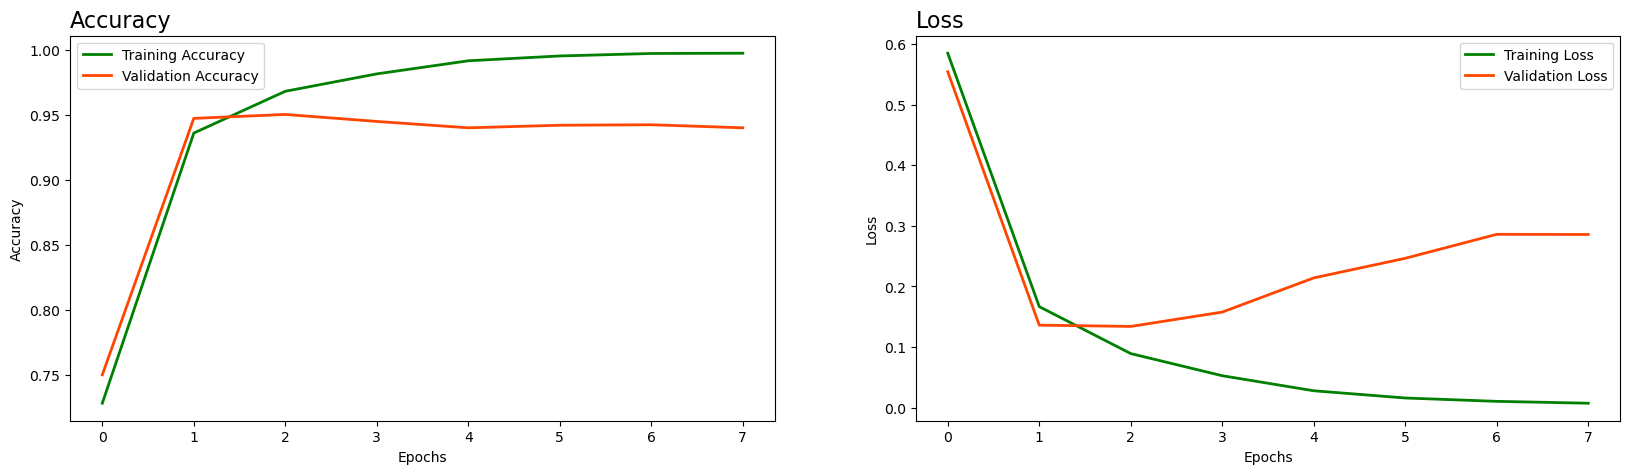

In [45]:
results = model.evaluate(test_padded, test_labels, verbose=1)
plot_history(history)

In [46]:
predictions = model.predict(test_padded)
model_prediction = np.where(predictions > 0.5, 1, 0)
from sklearn import metrics
model_performance = metrics.classification_report(test_labels,model_prediction, target_names= ['0', '1'])
print(model_performance)

276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2463
           1       0.96      0.97      0.97      6356

    accuracy                           0.95      8819
   macro avg       0.94      0.94      0.94      8819
weighted avg       0.95      0.95      0.95      8819



### Code Cell 8 (10%) - Build an LSTM model with trainable GloVe embeddings and show model performance 

In [47]:
from keras.layers import Input, Embedding, LSTM, Dense

# Ensure word_index, embedding_dim, max_length, and embedding_matrix are defined
# word_index: Dictionary mapping words to integer indices
# embedding_dim: Dimension of the GloVe embeddings (e.g., 50, 100, 300)
# max_length: Maximum sequence length for input data
# embedding_matrix: Pre-trained GloVe embedding matrix (shape: (vocab_size, embedding_dim))

# Define input layer
input_layer = Input(shape=(max_length,))  # Shape should match the input_length

# Embedding layer with pre-trained GloVe (Non-trainable)
embedding_layer = Embedding(
    input_dim=len(word_index) + 1,  # Vocabulary size (+1 for padding token)
    output_dim=embedding_dim,       # Embedding dimension (matches GloVe)
    input_length=max_length,        # Sequence length (fixed for model input)
    weights=[embedding_matrix],     # Load pre-trained embeddings
    trainable=True                 # set True for fine-tuning
)(input_layer)

# LSTM layer
lstm_layer = LSTM(64)(embedding_layer)

# Fully connected layers
dense_layer = Dense(24, activation='relu')(lstm_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)  # Binary classification output

# Define the Functional model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 100, 100)       │     2,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,043,925 (7.80 MB)

 Trainable params: 2,043,925 (7.80 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# fit model
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True)
num_epochs=50
# num_epochs = 2
history = model.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)

Epoch 1/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7371 - loss: 0.5724 - val_accuracy: 0.8208 - val_loss: 0.4256
Epoch 2/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7592 - loss: 0.5097 - val_accuracy: 0.7264 - val_loss: 0.5796
Epoch 3/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7839 - loss: 0.4708 - val_accuracy: 0.9372 - val_loss: 0.1684
Epoch 4/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9507 - loss: 0.1410 - val_accuracy: 0.9470 - val_loss: 0.1421
Epoch 5/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9730 - loss: 0.0833 - val_accuracy: 0.9464 - val_loss: 0.1428
Epoch 6/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9806 - loss: 0.0658 - val_accuracy: 0.9457 - val_loss: 0.1593
Epoch 7/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9876 - loss: 0.0416 - val_accuracy: 0.9442 - val_loss: 0.1665
Epoch 8/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9934 - loss: 0.0258 - val_accuracy: 0.

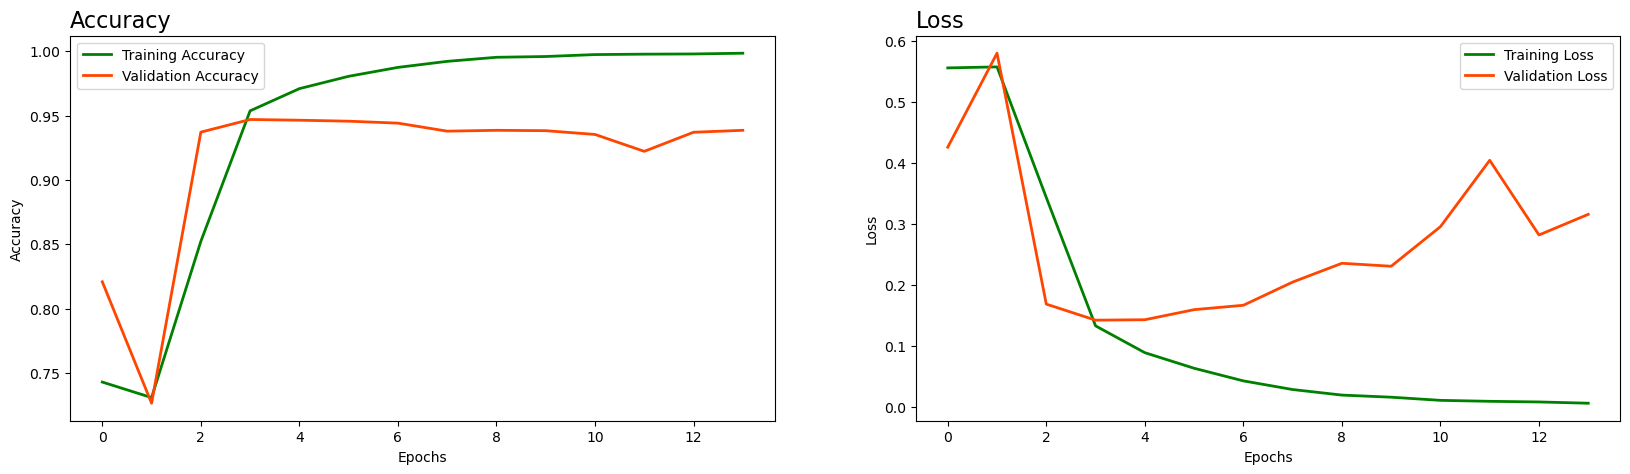

In [49]:
plot_history(history)

In [50]:
results = model.evaluate(test_padded, test_labels, verbose=1)
predictions = model.predict(test_padded)
model_prediction = np.where(predictions > 0.5, 1, 0)
model_performance = metrics.classification_report(test_labels,model_prediction, target_names= ['0', '1'])
print(model_performance)

276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9482 - loss: 0.1393
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2463
           1       0.96      0.96      0.96      6356

    accuracy                           0.94      8819
   macro avg       0.93      0.93      0.93      8819
weighted avg       0.94      0.94      0.94      8819



### Code Cell 9 (5%) - Use your best model in your Lab assignment 2 and show the performance 

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_sentences)
X_test_tfidf = tfidf_vectorizer.transform(test_sentences)

log_reg = LogisticRegression(max_iter=1000)
history = log_reg.fit(X_train_tfidf, train_labels)

test_predictions = log_reg.predict(X_test_tfidf)

model_prediction = np.where(test_predictions > 0.5, 1, 0)
model_performance = metrics.classification_report(test_labels,model_prediction, target_names= ['0', '1'])
print(model_performance)

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      2463
           1       0.96      0.97      0.97      6356

    accuracy                           0.95      8819
   macro avg       0.94      0.93      0.94      8819
weighted avg       0.95      0.95      0.95      8819



###  Text Cell 10 (10%) - Compare and comment on your observations on the performance of different deep learning models and different embeddings (i.e.,  LSTM and GRU).

* GRU slightly outperforms LSTM when embeddings are trainable (Model 3 vs. Model 4), but they’re nearly identical with pre-trained embeddings (Model 1 vs. Model 2).

* Trainable GloVe outperforms pre-trained GloVe, suggesting that fine-tuning embeddings to the task improves results.
                                                                                                                                               
* Logistic Regression with TF-IDF (Model 5) matches or exceeds deep learning models in accuracy and F1-scores, despite being simpler and faster to train.
                                                                                                                                               
* For this dataset, Model 5 (Logistic Regression with TF-IDF) or Model 3 (GRU with trainable GloVe) are the best choices                                                                                                                                               

### Text Cell 11 (5%) - Acknowledge if you have used any GenAI tools in this assignment and anyone you have worked with on this assignment. 

I have referred to professor's code file and took help from chatgpt for syntax issues.

### Code Cell 12(5%) - Render HTML output for this assignment and make sure the output of each cell is shown. 

In [2]:
!jupyter nbconvert "LA4_Shah_Rhythm.ipynb" --to html

[NbConvertApp] Converting notebook LA4_Shah_Rhythm.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 759233 bytes to LA4_Shah_Rhythm.html
